In [ ]:
# Install dependencies
!pip install roboflow
!pip install -U opencv-python-headless
!pip install -q torch torchvision torchaudio
!pip install -q pycocotools

# Install Detectron2
!pip install -q git+https://github.com/facebookresearch/detectron2.git


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 117.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 17.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.10.0.84
    Uninstalling opencv-python-headless-4.10.0.84:
      Successfully uninstalled opencv-python-headless-4.10.0.84
ERROR: pip'

In [8]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="KfxOK25zwTBSPfjF0KtJ")
project = rf.workspace("aaa-vkhh2").project("bener-100")
version = project.version(2)
dataset = version.download("coco")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to bener-100-2 in coco:: 100%|██████████| 139/139 [00:00<00:00, 2071.48it/s]


In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="KfxOK25zwTBSPfjF0KtJ")
project = rf.workspace("aaa-vkhh2").project("bener-100")
version = project.version(2)
dataset = version.download("coco-segmentation")

  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (49.9 MB)
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to bener-100-2 in coco-segmentation:: 100%|██████████| 139/139 [00:00<00:00, 1782.67it/s]


In [11]:
import json

with open("/content/bener-100-2/train/_annotations_filtered.coco.json") as f:
    data = json.load(f)

print("Daftar kelas dalam file JSON:")
for cat in data["categories"]:
    print(f"- id: {cat['id']}, name: {cat['name']}")


Daftar kelas dalam file JSON:
- id: 1, name: msk


In [10]:
import json

# Load data COCO
with open("/content/bener-100-2/train/_annotations.coco.json") as f:
    data = json.load(f)

# Cek kategori yang ingin disimpan (msk)
kategori_dipakai = [cat for cat in data["categories"] if cat["name"] == "msk"]

# Ambil id kategori yang dipakai
id_kategori_dipakai = set(cat["id"] for cat in kategori_dipakai)

# Filter annotations hanya yang pakai kategori id msk
annotations_baru = [anno for anno in data["annotations"] if anno["category_id"] in id_kategori_dipakai]

# Ambil image ids yang punya annotations kategori msk
image_ids_dipakai = set(anno["image_id"] for anno in annotations_baru)

# Filter images hanya yang ada dalam annotations msk
images_baru = [img for img in data["images"] if img["id"] in image_ids_dipakai]

# Update data
data["categories"] = kategori_dipakai
data["annotations"] = annotations_baru
data["images"] = images_baru

# Simpan ke file baru
with open("/content/bener-100-2/train/_annotations_filtered.coco.json", "w") as f:
    json.dump(data, f, indent=2)

print("Kategori selain 'msk' sudah dihapus dan file disimpan sebagai '_annotations_filtered.coco.json'")


Kategori selain 'msk' sudah dihapus dan file disimpan sebagai '_annotations_filtered.coco.json'


In [12]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
import os

# Registrasi dataset
from detectron2.data.datasets import register_coco_instances

register_coco_instances("bener150_train", {},
    "/content/bener-100-2/train/_annotations_filtered.coco.json",
    "/content/bener-100-2/train")

register_coco_instances("bener150_valid", {},
    "/content/bener-100-2/valid/_annotations_filtered.coco.json",
    "/content/bener-100-2/valid")

from detectron2.data import MetadataCatalog
MetadataCatalog.get("bener150_train").thing_classes = ["msk"]
MetadataCatalog.get("bener150_valid").thing_classes = ["msk"]


# Custom Trainer dengan evaluator
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, False, output_folder)

# Setup config
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("bener150_train",)
cfg.DATASETS.TEST = ("bener150_valid",)
cfg.DATALOADER.NUM_WORKERS = 2

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 3000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Karena ada 2 kategori

cfg.OUTPUT_DIR = "./output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Training
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# Testing dan evaluasi
evaluator = COCOEvaluator("bener150_valid", cfg, False, output_dir="./output/inference")
val_loader = build_detection_test_loader(cfg, "bener150_valid")
metrics = inference_on_dataset(trainer.model, val_loader, evaluator)
print(metrics)


[05/20 07:19:43 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:00, 208MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[05/20 07:19:45 d2.engine.train_loop]: Starting training from iteration 0


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)


[05/20 07:19:53 d2.utils.events]:  eta: 0:12:28  iter: 19  total_loss: 4.946  loss_cls: 0.6858  loss_box_reg: 0.2354  loss_rpn_cls: 3.332  loss_rpn_loc: 0.7345    time: 0.2495  last_time: 0.3120  data_time: 0.0179  last_data_time: 0.0095   lr: 4.9953e-06  max_mem: 3703M
[05/20 07:20:09 d2.utils.events]:  eta: 0:12:20  iter: 39  total_loss: 3.332  loss_cls: 0.6632  loss_box_reg: 0.3715  loss_rpn_cls: 1.755  loss_rpn_loc: 0.5539    time: 0.2460  last_time: 0.2418  data_time: 0.0038  last_data_time: 0.0038   lr: 9.9902e-06  max_mem: 3703M
[05/20 07:20:14 d2.utils.events]:  eta: 0:12:10  iter: 59  total_loss: 2.067  loss_cls: 0.635  loss_box_reg: 0.3194  loss_rpn_cls: 0.5166  loss_rpn_loc: 0.5543    time: 0.2438  last_time: 0.2531  data_time: 0.0031  last_data_time: 0.0040   lr: 1.4985e-05  max_mem: 3703M
[05/20 07:20:18 d2.utils.events]:  eta: 0:11:49  iter: 79  total_loss: 1.787  loss_cls: 0.5801  loss_box_reg: 0.4152  loss_rpn_cls: 0.2973  loss_rpn_loc: 0.4852    time: 0.2416  last_time

In [13]:
!git clone https://github.com/abewley/sort.git
%cd sort


Cloning into 'sort'...
remote: Enumerating objects: 208, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 208 (delta 2), reused 1 (delta 1), pack-reused 203 (from 2)
Receiving objects: 100% (208/208), 1.20 MiB | 15.82 MiB/s, done.
Resolving deltas: 100% (74/74), done.
/content/sort
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.8/29.8 MB 20.3 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not p

In [20]:
!pip install -r requirements.txt


  Using cached filterpy-1.4.5.zip (177 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 28.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110460 sha256=0a2ce61f9c31391b2888be2d11d79c4ed94652ef5fc0be529da9a6800f3ae3ea
  Stored in directory: /root/.cache/pip/wheels/12/dc/3c/e12983eac132d00f82a20c6cbe7b42ce6e96190ef8fa2d15e1
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for lap
  Running setup.py clean for lap
Successfully built filterpy
Failed to build lap
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (lap)


In [21]:
!apt-get install -y liblap-dev


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package liblap-dev


In [22]:
!pip install lap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.8 MB/s eta 0:00:00


In [17]:
import cv2
import torch
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
from google.colab.patches import cv2_imshow

# Setup config Faster R-CNN
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # kelas msk
cfg.MODEL.WEIGHTS = "/content/output/model_final.pth"  # model hasil training kamu
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3  # threshold confidence
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

predictor = DefaultPredictor(cfg)

# Load gambar
image_path = "/content/frame2_1007.jpg"
im = cv2.imread(image_path)

# Inferensi
outputs = predictor(im)

# Visualisasi hasil prediksi
metadata = MetadataCatalog.get("bener150_train")  # dataset yang sudah kamu register
v = Visualizer(im[:, :, ::-1], metadata=metadata, scale=1.0, instance_mode=ColorMode.SEGMENTATION)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow("Prediksi", out.get_image()[:, :, ::-1])
cv2.waitKey(0)


[05/20 07:37:44 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


TypeError: cv2_imshow() takes 1 positional argument but 2 were given

[05/20 08:02:58 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


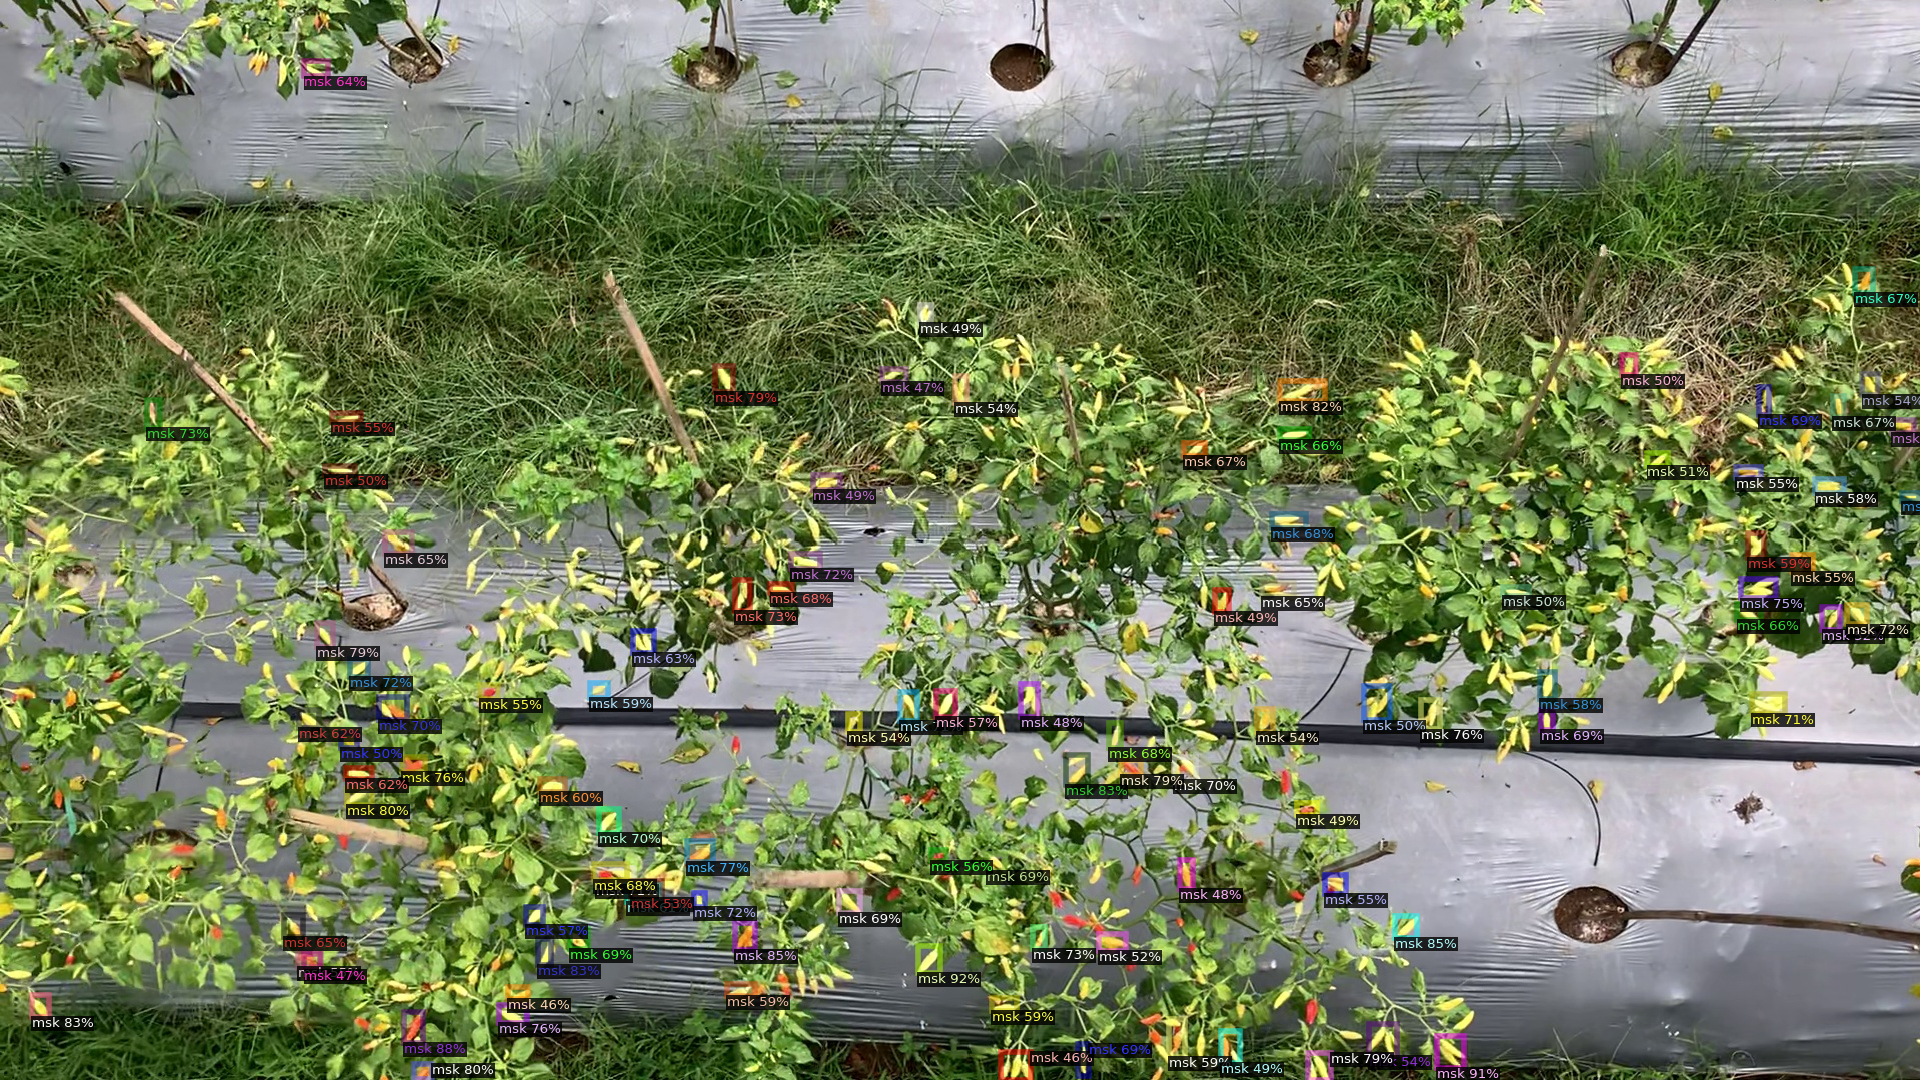

In [40]:
import cv2
import torch
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
from google.colab.patches import cv2_imshow

# Setup config Faster R-CNN
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # kelas msk
cfg.MODEL.WEIGHTS = "/content/output/model_final.pth"  # model hasil training kamu
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3  # threshold confidence
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

predictor = DefaultPredictor(cfg)

# Load gambar
image_path = "/content/frame2_1007.jpg"
# Corrected function call from cv2_imread to cv2.imread
im = cv2.imread(image_path)

# Inferensi
outputs = predictor(im)

# Visualisasi hasil prediksi
metadata = MetadataCatalog.get("bener150_train")  # dataset yang sudah kamu register
v = Visualizer(im[:, :, ::-1], metadata=metadata, scale=1.0, instance_mode=ColorMode.SEGMENTATION)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Corrected cv2_imshow call - removed the window name argument
cv2_imshow(out.get_image()[:, :, ::-1])


In [24]:
# prompt: connect google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import torch
import numpy as np
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from sort import Sort  # Pastikan file sort.py tersedia
from detectron2.data import MetadataCatalog

# Konfigurasi model Detectron2
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Ganti sesuai jumlah kelasmu (1 untuk cabai)
cfg.MODEL.WEIGHTS = "/content/output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

predictor = DefaultPredictor(cfg)

# Load video
cap = cv2.VideoCapture("/content/aman2.MOV")
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Output video
out = cv2.VideoWriter('detectron2_sort_output.mp4',
                      cv2.VideoWriter_fourcc(*'mp4v'),
                      fps, (frame_width, frame_height))

# Parameter garis kanan
garis_kanan = frame_width - 80
total_lewat = 0
sudah_dihitung = set()
track_history = {}

# Inisialisasi tracker SORT
tracker = Sort()

while True:
    ret, frame = cap.read()
    if not ret:
        break

    outputs = predictor(frame)
    instances = outputs["instances"].to("cpu")
    boxes = instances.pred_boxes.tensor.numpy()
    scores = instances.scores.numpy()

    # Siapkan deteksi untuk SORT
    detections = []
    for box, score in zip(boxes, scores):
        if score > 0.3:
            x1, y1, x2, y2 = box
            detections.append([x1, y1, x2, y2, score])

    dets = np.array(detections) if detections else np.empty((0, 5))
    tracks = tracker.update(dets)

    for track in tracks:
        x1, y1, x2, y2, track_id = track.astype(int)
        cx = int((x1 + x2) / 2)

        # Gambar bounding box dan ID
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(frame, f'', (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

        # Hitung crossing garis kanan
        if track_id in track_history:
            prev_cx = track_history[track_id]
            if prev_cx < garis_kanan and cx >= garis_kanan and track_id not in sudah_dihitung:
                total_lewat += 1
                sudah_dihitung.add(track_id)
        track_history[track_id] = cx


    # Gambar garis dan counter
    cv2.line(frame, (garis_kanan, 0), (garis_kanan, frame_height), (0, 255, 0), 2)
    cv2.putText(frame, f"Cabai lewat: {total_lewat}", (10, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    out.write(frame)

cap.release()
out.release()


[05/20 08:13:27 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


In [ ]:
# prompt: compress video

# Install necessary library for video compression
!pip install ffmpeg-python

import ffmpeg

input_video = 'detectron2_sort_output.mp4'
output_video_compressed = 'detectron2_sort_output_compressed.mp4'

try:
    (
        ffmpeg
        .input(input_video)
        .output(output_video_compressed, crf=28) # CRF (Constant Rate Factor) controls compression quality
        .run()
    )
    print(f"Video compressed and saved as {output_video_compressed}")
except ffmpeg.Error as e:
    print('ffmpeg error:', e.stderr.decode('utf8'))
except FileNotFoundError:
    print(f"Error: Input video file '{input_video}' not found. Make sure the output video from the previous step was successfully created.")



In [ ]:
# prompt: download video

from google.colab import files
files.download('detectron2_sort_output_compressed.mp4')

In [28]:
import cv2
import numpy as np
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from sort import Sort

# ===== Load model Faster R-CNN =====
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Kalau kamu punya model custom, ganti di sini load checkpointnya
model = fasterrcnn_resnet50_fpn(pretrained=False, num_classes=2)  # 2 classes (background + cabai)
model.load_state_dict(torch.load('/content/output/model_final.pth', map_location=device))
model.to(device)
model.eval()

# ===== Load video =====
cap = cv2.VideoCapture('shalmann/shalman/aman2.MOV')
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

out = cv2.VideoWriter('output_cabai_frcnn_sort.mp4',
                      cv2.VideoWriter_fourcc(*'mp4v'),
                      fps, (frame_width, frame_height))

garis_kanan = frame_width - 80
total_lewat = 0
sudah_dihitung = set()
track_history = {}

tracker = Sort()

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess frame for Faster R-CNN
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_tensor = F.to_tensor(img_rgb).to(device)

    with torch.no_grad():
        outputs = model([img_tensor])

    # Ambil output
    boxes = outputs[0]['boxes'].cpu().numpy()
    scores = outputs[0]['scores'].cpu().numpy()
    labels = outputs[0]['labels'].cpu().numpy()

    detections = []
    conf_threshold = 0.25

    for box, score, label in zip(boxes, scores, labels):
        if score < conf_threshold:
            continue
        # Asumsi label 1 = cabai
        if label == 1:
            x1, y1, x2, y2 = box.astype(int)
            detections.append([x1, y1, x2, y2, score])

    dets = np.array(detections) if detections else np.empty((0, 5))
    tracks = tracker.update(dets)

    for track in tracks:
        x1, y1, x2, y2, track_id = track.astype(int)
        cx = int((x1 + x2) / 2)

        # Gambar box dan ID
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(frame, f'ID: {track_id}', (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

        # Hitung crossing garis kanan
        if track_id in track_history:
            prev_cx = track_history[track_id]
            if prev_cx < garis_kanan and cx >= garis_kanan and track_id not in sudah_dihitung:
                total_lewat += 1
                sudah_dihitung.add(track_id)
        track_history[track_id] = cx

    # Gambar garis dan jumlah count
    cv2.line(frame, (garis_kanan, 0), (garis_kanan, frame_height), (0, 255, 0), 2)
    cv2.putText(frame, f"Cabai lewat: {total_lewat}", (10, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    out.write(frame)

cap.release()
out.release()


ImportError: Cannot load backend 'TkAgg' which requires the 'tk' interactive framework, as 'headless' is currently running

In [38]:
import cv2
import torch
import numpy as np
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from sort import Sort  # Pastikan file sort.py tersedia
from detectron2.data import MetadataCatalog

# Konfigurasi model Detectron2
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Ganti sesuai jumlah kelasmu (1 untuk cabai)
cfg.MODEL.WEIGHTS = "/content/output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

predictor = DefaultPredictor(cfg)

# Load video
cap = cv2.VideoCapture("/content/drive/MyDrive/fasterrcnn/aman2.MOV")
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Output video
out = cv2.VideoWriter('detectron2_sort_output.mp4',
                      cv2.VideoWriter_fourcc(*'mp4v'),
                      fps, (frame_width, frame_height))

# Parameter garis kanan
garis_kanan = frame_width - 80
total_lewat = 0
sudah_dihitung = set()
track_history = {}

# Inisialisasi tracker SORT
tracker = Sort()

while True:
    ret, frame = cap.read()
    if not ret:
        break

    outputs = predictor(frame)
    instances = outputs["instances"].to("cpu")
    boxes = instances.pred_boxes.tensor.numpy()
    scores = instances.scores.numpy()

    # Siapkan deteksi untuk SORT
    detections = []
    for box, score in zip(boxes, scores):
        if score > 0.3:
            x1, y1, x2, y2 = box
            detections.append([x1, y1, x2, y2, score])

    dets = np.array(detections) if detections else np.empty((0, 5))
    tracks = tracker.update(dets)

    for track in tracks:
        x1, y1, x2, y2, track_id = track.astype(int)
        cx = int((x1 + x2) / 2)

        # Gambar bounding box dan ID
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(frame, f'', (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

        # Hitung crossing garis kanan
        if track_id in track_history:
            prev_cx = track_history[track_id]
            if prev_cx < garis_kanan and cx >= garis_kanan and track_id not in sudah_dihitung:
                total_lewat += 1
                sudah_dihitung.add(track_id)
        track_history[track_id] = cx

    # Gambar garis dan counter
    cv2.line(frame, (garis_kanan, 0), (garis_kanan, frame_height), (0, 255, 0), 2)
    cv2.putText(frame, f"Cabai lewat: {total_lewat}", (10, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    out.write(frame)

cap.release()
out.release()


[05/20 07:58:19 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


KeyboardInterrupt: 

In [31]:
!pip install filterpy==1.4.5 --no-binary :all:


  Using cached filterpy-1.4.5-py3-none-any.whl


In [35]:
import cv2
import numpy as np
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import matplotlib
matplotlib.use('Agg')  # Tambahkan ini sebelum import pyplot

from sort import Sort
import matplotlib.pyplot as plt

# ===== Load model Faster R-CNN =====
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Kalau kamu punya model custom, ganti di sini load checkpointnya
model = fasterrcnn_resnet50_fpn(pretrained=False, num_classes=2)  # 2 classes (background + cabai)
model.load_state_dict(torch.load('/content/output/model_final.pth', map_location=device))
model.to(device)
model.eval()

# ===== Load video =====
cap = cv2.VideoCapture('/content/drive/MyDrive/fasterrcnn/aman2.MOV')
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

out = cv2.VideoWriter('output_cabai_frcnn_sort2.mp4',
                      cv2.VideoWriter_fourcc(*'mp4v'),
                      fps, (frame_width, frame_height))

garis_kanan = frame_width - 80
total_lewat = 0
sudah_dihitung = set()
track_history = {}

tracker = Sort()

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess frame for Faster R-CNN
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_tensor = F.to_tensor(img_rgb).to(device)

    with torch.no_grad():
        outputs = model([img_tensor])

    # Ambil output
    boxes = outputs[0]['boxes'].cpu().numpy()
    scores = outputs[0]['scores'].cpu().numpy()
    labels = outputs[0]['labels'].cpu().numpy()

    detections = []
    conf_threshold = 0.3

    for box, score, label in zip(boxes, scores, labels):
        if score < conf_threshold:
            continue
        # Asumsi label 1 = cabai
        if label == 1:
            x1, y1, x2, y2 = box.astype(int)
            detections.append([x1, y1, x2, y2, score])

    dets = np.array(detections) if detections else np.empty((0, 5))
    tracks = tracker.update(dets)

    for track in tracks:
        x1, y1, x2, y2, track_id = track.astype(int)
        cx = int((x1 + x2) / 2)

        # Gambar box dan ID
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(frame, f'ID: {track_id}', (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

        # Hitung crossing garis kanan
        if track_id in track_history:
            prev_cx = track_history[track_id]
            if prev_cx < garis_kanan and cx >= garis_kanan and track_id not in sudah_dihitung:
                total_lewat += 1
                sudah_dihitung.add(track_id)
        track_history[track_id] = cx

    # Gambar garis dan jumlah count
    cv2.line(frame, (garis_kanan, 0), (garis_kanan, frame_height), (0, 255, 0), 2)
    cv2.putText(frame, f"Cabai lewat: {total_lewat}", (10, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    out.write(frame)

cap.release()
out.release()


RuntimeError: Error(s) in loading state_dict for FasterRCNN:
	Missing key(s) in state_dict: "backbone.body.conv1.weight", "backbone.body.bn1.weight", "backbone.body.bn1.bias", "backbone.body.bn1.running_mean", "backbone.body.bn1.running_var", "backbone.body.layer1.0.conv1.weight", "backbone.body.layer1.0.bn1.weight", "backbone.body.layer1.0.bn1.bias", "backbone.body.layer1.0.bn1.running_mean", "backbone.body.layer1.0.bn1.running_var", "backbone.body.layer1.0.conv2.weight", "backbone.body.layer1.0.bn2.weight", "backbone.body.layer1.0.bn2.bias", "backbone.body.layer1.0.bn2.running_mean", "backbone.body.layer1.0.bn2.running_var", "backbone.body.layer1.0.conv3.weight", "backbone.body.layer1.0.bn3.weight", "backbone.body.layer1.0.bn3.bias", "backbone.body.layer1.0.bn3.running_mean", "backbone.body.layer1.0.bn3.running_var", "backbone.body.layer1.0.downsample.0.weight", "backbone.body.layer1.0.downsample.1.weight", "backbone.body.layer1.0.downsample.1.bias", "backbone.body.layer1.0.downsample.1.running_mean", "backbone.body.layer1.0.downsample.1.running_var", "backbone.body.layer1.1.conv1.weight", "backbone.body.layer1.1.bn1.weight", "backbone.body.layer1.1.bn1.bias", "backbone.body.layer1.1.bn1.running_mean", "backbone.body.layer1.1.bn1.running_var", "backbone.body.layer1.1.conv2.weight", "backbone.body.layer1.1.bn2.weight", "backbone.body.layer1.1.bn2.bias", "backbone.body.layer1.1.bn2.running_mean", "backbone.body.layer1.1.bn2.running_var", "backbone.body.layer1.1.conv3.weight", "backbone.body.layer1.1.bn3.weight", "backbone.body.layer1.1.bn3.bias", "backbone.body.layer1.1.bn3.running_mean", "backbone.body.layer1.1.bn3.running_var", "backbone.body.layer1.2.conv1.weight", "backbone.body.layer1.2.bn1.weight", "backbone.body.layer1.2.bn1.bias", "backbone.body.layer1.2.bn1.running_mean", "backbone.body.layer1.2.bn1.running_var", "backbone.body.layer1.2.conv2.weight", "backbone.body.layer1.2.bn2.weight", "backbone.body.layer1.2.bn2.bias", "backbone.body.layer1.2.bn2.running_mean", "backbone.body.layer1.2.bn2.running_var", "backbone.body.layer1.2.conv3.weight", "backbone.body.layer1.2.bn3.weight", "backbone.body.layer1.2.bn3.bias", "backbone.body.layer1.2.bn3.running_mean", "backbone.body.layer1.2.bn3.running_var", "backbone.body.layer2.0.conv1.weight", "backbone.body.layer2.0.bn1.weight", "backbone.body.layer2.0.bn1.bias", "backbone.body.layer2.0.bn1.running_mean", "backbone.body.layer2.0.bn1.running_var", "backbone.body.layer2.0.conv2.weight", "backbone.body.layer2.0.bn2.weight", "backbone.body.layer2.0.bn2.bias", "backbone.body.layer2.0.bn2.running_mean", "backbone.body.layer2.0.bn2.running_var", "backbone.body.layer2.0.conv3.weight", "backbone.body.layer2.0.bn3.weight", "backbone.body.layer2.0.bn3.bias", "backbone.body.layer2.0.bn3.running_mean", "backbone.body.layer2.0.bn3.running_var", "backbone.body.layer2.0.downsample.0.weight", "backbone.body.layer2.0.downsample.1.weight", "backbone.body.layer2.0.downsample.1.bias", "backbone.body.layer2.0.downsample.1.running_mean", "backbone.body.layer2.0.downsample.1.running_var", "backbone.body.layer2.1.conv1.weight", "backbone.body.layer2.1.bn1.weight", "backbone.body.layer2.1.bn1.bias", "backbone.body.layer2.1.bn1.running_mean", "backbone.body.layer2.1.bn1.running_var", "backbone.body.layer2.1.conv2.weight", "backbone.body.layer2.1.bn2.weight", "backbone.body.layer2.1.bn2.bias", "backbone.body.layer2.1.bn2.running_mean", "backbone.body.layer2.1.bn2.running_var", "backbone.body.layer2.1.conv3.weight", "backbone.body.layer2.1.bn3.weight", "backbone.body.layer2.1.bn3.bias", "backbone.body.layer2.1.bn3.running_mean", "backbone.body.layer2.1.bn3.running_var", "backbone.body.layer2.2.conv1.weight", "backbone.body.layer2.2.bn1.weight", "backbone.body.layer2.2.bn1.bias", "backbone.body.layer2.2.bn1.running_mean", "backbone.body.layer2.2.bn1.running_var", "backbone.body.layer2.2.conv2.weight", "backbone.body.layer2.2.bn2.weight", "backbone.body.layer2.2.bn2.bias", "backbone.body.layer2.2.bn2.running_mean", "backbone.body.layer2.2.bn2.running_var", "backbone.body.layer2.2.conv3.weight", "backbone.body.layer2.2.bn3.weight", "backbone.body.layer2.2.bn3.bias", "backbone.body.layer2.2.bn3.running_mean", "backbone.body.layer2.2.bn3.running_var", "backbone.body.layer2.3.conv1.weight", "backbone.body.layer2.3.bn1.weight", "backbone.body.layer2.3.bn1.bias", "backbone.body.layer2.3.bn1.running_mean", "backbone.body.layer2.3.bn1.running_var", "backbone.body.layer2.3.conv2.weight", "backbone.body.layer2.3.bn2.weight", "backbone.body.layer2.3.bn2.bias", "backbone.body.layer2.3.bn2.running_mean", "backbone.body.layer2.3.bn2.running_var", "backbone.body.layer2.3.conv3.weight", "backbone.body.layer2.3.bn3.weight", "backbone.body.layer2.3.bn3.bias", "backbone.body.layer2.3.bn3.running_mean", "backbone.body.layer2.3.bn3.running_var", "backbone.body.layer3.0.conv1.weight", "backbone.body.layer3.0.bn1.weight", "backbone.body.layer3.0.bn1.bias", "backbone.body.layer3.0.bn1.running_mean", "backbone.body.layer3.0.bn1.running_var", "backbone.body.layer3.0.conv2.weight", "backbone.body.layer3.0.bn2.weight", "backbone.body.layer3.0.bn2.bias", "backbone.body.layer3.0.bn2.running_mean", "backbone.body.layer3.0.bn2.running_var", "backbone.body.layer3.0.conv3.weight", "backbone.body.layer3.0.bn3.weight", "backbone.body.layer3.0.bn3.bias", "backbone.body.layer3.0.bn3.running_mean", "backbone.body.layer3.0.bn3.running_var", "backbone.body.layer3.0.downsample.0.weight", "backbone.body.layer3.0.downsample.1.weight", "backbone.body.layer3.0.downsample.1.bias", "backbone.body.layer3.0.downsample.1.running_mean", "backbone.body.layer3.0.downsample.1.running_var", "backbone.body.layer3.1.conv1.weight", "backbone.body.layer3.1.bn1.weight", "backbone.body.layer3.1.bn1.bias", "backbone.body.layer3.1.bn1.running_mean", "backbone.body.layer3.1.bn1.running_var", "backbone.body.layer3.1.conv2.weight", "backbone.body.layer3.1.bn2.weight", "backbone.body.layer3.1.bn2.bias", "backbone.body.layer3.1.bn2.running_mean", "backbone.body.layer3.1.bn2.running_var", "backbone.body.layer3.1.conv3.weight", "backbone.body.layer3.1.bn3.weight", "backbone.body.layer3.1.bn3.bias", "backbone.body.layer3.1.bn3.running_mean", "backbone.body.layer3.1.bn3.running_var", "backbone.body.layer3.2.conv1.weight", "backbone.body.layer3.2.bn1.weight", "backbone.body.layer3.2.bn1.bias", "backbone.body.layer3.2.bn1.running_mean", "backbone.body.layer3.2.bn1.running_var", "backbone.body.layer3.2.conv2.weight", "backbone.body.layer3.2.bn2.weight", "backbone.body.layer3.2.bn2.bias", "backbone.body.layer3.2.bn2.running_mean", "backbone.body.layer3.2.bn2.running_var", "backbone.body.layer3.2.conv3.weight", "backbone.body.layer3.2.bn3.weight", "backbone.body.layer3.2.bn3.bias", "backbone.body.layer3.2.bn3.running_mean", "backbone.body.layer3.2.bn3.running_var", "backbone.body.layer3.3.conv1.weight", "backbone.body.layer3.3.bn1.weight", "backbone.body.layer3.3.bn1.bias", "backbone.body.layer3.3.bn1.running_mean", "backbone.body.layer3.3.bn1.running_var", "backbone.body.layer3.3.conv2.weight", "backbone.body.layer3.3.bn2.weight", "backbone.body.layer3.3.bn2.bias", "backbone.body.layer3.3.bn2.running_mean", "backbone.body.layer3.3.bn2.running_var", "backbone.body.layer3.3.conv3.weight", "backbone.body.layer3.3.bn3.weight", "backbone.body.layer3.3.bn3.bias", "backbone.body.layer3.3.bn3.running_mean", "backbone.body.layer3.3.bn3.running_var", "backbone.body.layer3.4.conv1.weight", "backbone.body.layer3.4.bn1.weight", "backbone.body.layer3.4.bn1.bias", "backbone.body.layer3.4.bn1.running_mean", "backbone.body.layer3.4.bn1.running_var", "backbone.body.layer3.4.conv2.weight", "backbone.body.layer3.4.bn2.weight", "backbone.body.layer3.4.bn2.bias", "backbone.body.layer3.4.bn2.running_mean", "backbone.body.layer3.4.bn2.running_var", "backbone.body.layer3.4.conv3.weight", "backbone.body.layer3.4.bn3.weight", "backbone.body.layer3.4.bn3.bias", "backbone.body.layer3.4.bn3.running_mean", "backbone.body.layer3.4.bn3.running_var", "backbone.body.layer3.5.conv1.weight", "backbone.body.layer3.5.bn1.weight", "backbone.body.layer3.5.bn1.bias", "backbone.body.layer3.5.bn1.running_mean", "backbone.body.layer3.5.bn1.running_var", "backbone.body.layer3.5.conv2.weight", "backbone.body.layer3.5.bn2.weight", "backbone.body.layer3.5.bn2.bias", "backbone.body.layer3.5.bn2.running_mean", "backbone.body.layer3.5.bn2.running_var", "backbone.body.layer3.5.conv3.weight", "backbone.body.layer3.5.bn3.weight", "backbone.body.layer3.5.bn3.bias", "backbone.body.layer3.5.bn3.running_mean", "backbone.body.layer3.5.bn3.running_var", "backbone.body.layer4.0.conv1.weight", "backbone.body.layer4.0.bn1.weight", "backbone.body.layer4.0.bn1.bias", "backbone.body.layer4.0.bn1.running_mean", "backbone.body.layer4.0.bn1.running_var", "backbone.body.layer4.0.conv2.weight", "backbone.body.layer4.0.bn2.weight", "backbone.body.layer4.0.bn2.bias", "backbone.body.layer4.0.bn2.running_mean", "backbone.body.layer4.0.bn2.running_var", "backbone.body.layer4.0.conv3.weight", "backbone.body.layer4.0.bn3.weight", "backbone.body.layer4.0.bn3.bias", "backbone.body.layer4.0.bn3.running_mean", "backbone.body.layer4.0.bn3.running_var", "backbone.body.layer4.0.downsample.0.weight", "backbone.body.layer4.0.downsample.1.weight", "backbone.body.layer4.0.downsample.1.bias", "backbone.body.layer4.0.downsample.1.running_mean", "backbone.body.layer4.0.downsample.1.running_var", "backbone.body.layer4.1.conv1.weight", "backbone.body.layer4.1.bn1.weight", "backbone.body.layer4.1.bn1.bias", "backbone.body.layer4.1.bn1.running_mean", "backbone.body.layer4.1.bn1.running_var", "backbone.body.layer4.1.conv2.weight", "backbone.body.layer4.1.bn2.weight", "backbone.body.layer4.1.bn2.bias", "backbone.body.layer4.1.bn2.running_mean", "backbone.body.layer4.1.bn2.running_var", "backbone.body.layer4.1.conv3.weight", "backbone.body.layer4.1.bn3.weight", "backbone.body.layer4.1.bn3.bias", "backbone.body.layer4.1.bn3.running_mean", "backbone.body.layer4.1.bn3.running_var", "backbone.body.layer4.2.conv1.weight", "backbone.body.layer4.2.bn1.weight", "backbone.body.layer4.2.bn1.bias", "backbone.body.layer4.2.bn1.running_mean", "backbone.body.layer4.2.bn1.running_var", "backbone.body.layer4.2.conv2.weight", "backbone.body.layer4.2.bn2.weight", "backbone.body.layer4.2.bn2.bias", "backbone.body.layer4.2.bn2.running_mean", "backbone.body.layer4.2.bn2.running_var", "backbone.body.layer4.2.conv3.weight", "backbone.body.layer4.2.bn3.weight", "backbone.body.layer4.2.bn3.bias", "backbone.body.layer4.2.bn3.running_mean", "backbone.body.layer4.2.bn3.running_var", "backbone.fpn.inner_blocks.0.0.weight", "backbone.fpn.inner_blocks.0.0.bias", "backbone.fpn.inner_blocks.1.0.weight", "backbone.fpn.inner_blocks.1.0.bias", "backbone.fpn.inner_blocks.2.0.weight", "backbone.fpn.inner_blocks.2.0.bias", "backbone.fpn.inner_blocks.3.0.weight", "backbone.fpn.inner_blocks.3.0.bias", "backbone.fpn.layer_blocks.0.0.weight", "backbone.fpn.layer_blocks.0.0.bias", "backbone.fpn.layer_blocks.1.0.weight", "backbone.fpn.layer_blocks.1.0.bias", "backbone.fpn.layer_blocks.2.0.weight", "backbone.fpn.layer_blocks.2.0.bias", "backbone.fpn.layer_blocks.3.0.weight", "backbone.fpn.layer_blocks.3.0.bias", "rpn.head.conv.0.0.weight", "rpn.head.conv.0.0.bias", "rpn.head.cls_logits.weight", "rpn.head.cls_logits.bias", "rpn.head.bbox_pred.weight", "rpn.head.bbox_pred.bias", "roi_heads.box_head.fc6.weight", "roi_heads.box_head.fc6.bias", "roi_heads.box_head.fc7.weight", "roi_heads.box_head.fc7.bias", "roi_heads.box_predictor.cls_score.weight", "roi_heads.box_predictor.cls_score.bias", "roi_heads.box_predictor.bbox_pred.weight", "roi_heads.box_predictor.bbox_pred.bias". 
	Unexpected key(s) in state_dict: "model", "trainer", "iteration". 